In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import libpysal as lps
import mapclassify as mc
import geopandas as gpd
from matplotlib.gridspec import GridSpec
import time
import numpy as np
import scipy.stats as stats
import seaborn as sns
import plotly.graph_objs as go
import textwrap
from matplotlib.lines import Line2D
from matplotlib.ticker import FixedFormatter, FixedLocator, FormatStrFormatter, MultipleLocator
import colorsys
import matplotlib as mpl
import shap
import matplotlib.dates as mdates
import datetime
from mycolorpy import colorlist as mcp


plt.rcParams.update(
    {
        "font.family": "serif",
        "font.serif": "CMU Serif",
        "text.usetex": True,
        "font.size": 12,
        "font.weight": "normal",
        "figure.titlesize": "medium",
        "xtick.color": "black",
        "ytick.color": "black",
        "axes.labelcolor": "black",
        "text.color": "black",
        "savefig.dpi": 600,
        "figure.dpi": 150,
    }
)


def add_grid(ax):
    ax.set_axisbelow(True)
    ax.grid(True, which="both", ls="--", c="0.8")
    ax.spines.right.set_visible(False)
    ax.spines.top.set_visible(False)


colors = [
    "#1F77B4",
    "#FF7F0E",
    "#2CA02C",
    "#D62728",
    "#9467BD",
    "#8C564B",
    "#E377C2",
    "#7F7F7F",
    "#BCBD22",
    "#17BECF",
]

dynamic_factors = [
    "Google Symptom Search",
    "Weather",
    "Google Search Insights",
    "Unemployment Rate",
    "Online News Article Tone",
    "% Change in Deceased",
    "% Change in Confirmed Cases",
    "Google Symptom Search 1",
    "Google Symptom Search 2",
    "Google Symptom Search 3",
    "Google Symptom Search 4",
    "Google Symptom Search 5",
    "Weather 1",
    "Weather 2",
    "Weather 3",
    "Stringency Index",
    "Sentiment from Tweets (Topic 1)",
    "Sentiment from Tweets (Topic 2)",
    "Sentiment from Tweets (Topic 3)",
    "Sentiment from Tweets (Topic 4)",
    "Sentiment from Tweets (Topic 5)",
    "Sentiment from Tweets (Topic 6)",
    "Sentiment from Tweets (Topic 7)",
    "Sentiment from Tweets (Topic 8)",
    "Sentiment from Tweets (Topic 9)",
    "Sentiment from Tweets (Topic 10)",
    "Sentiment from Tweets (Topic 11)",
    "Sentiment from Tweets (Topic 12)",
    "Sentiment from Tweets (Topic 13)",
    "Sentiment from Tweets (Topic 14)",
    "Sentiment from Tweets (Topic 15)",
    "Sentiment from Tweets (Topic 16)",
    "Sentiment from Tweets (Topic 17)",
]

data_folder = "Data"
image_folder = "/Users/htbui/Active Projects/Project Stochastic Programming/visualization/Proposal/paper 1"

# Figure 4


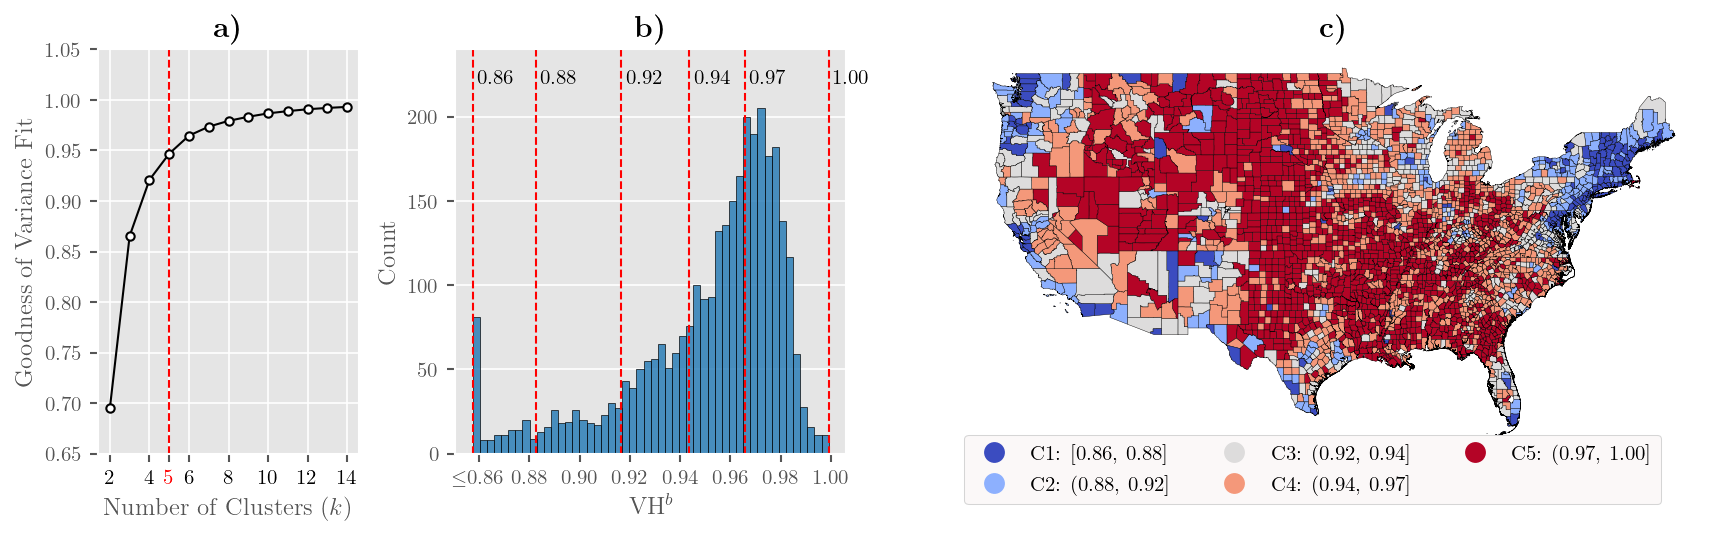

In [38]:
def get_surrounded_counties(df, wq, fips, verbose=True):
    lookup_idx = df[df["fips"] == fips].index.values[0]
    sur_df = df[df.index.isin(wq[lookup_idx].keys())]
    sur_fips = sur_df["fips"].values
    sur_counties = sur_df["county"].values
    print(f"+ Surrounded counties: {', '.join(sur_counties)}") if verbose else None
    return (sur_df, sur_fips)


def fill_missing_values_with_mean(df, wq, missing_fips, fill_col):
    sur_df, _ = get_surrounded_counties(df, wq, missing_fips, verbose=False)
    mean_val = sur_df[fill_col].mean()
    return mean_val


def fill_missing_VHb_surrounding_counties(df, wq, verbose=True):
    """Fill missing VHb values with mean of surrounding counties

    Args:
        df (DataFrame): Dataframe with VHb values
        wq (Weight Object): Weight object
        verbose (bool, optional): Print some statement. Defaults to True.

    Returns:
        DataFrame: Dataframe with filled VHb values
    """
    missing_fips_list = df[df["VHb"].isna()]["fips"].to_list()
    count_before = len(missing_fips_list)
    for fips in missing_fips_list:
        fips_idx = df[df["fips"] == fips].index[0]
        fill_val = fill_missing_values_with_mean(df, wq, fips, "VHb")
        df.loc[fips_idx, "VHb"] = fill_val

    count_after = df[df["VHb"].isna()].shape[0]
    print(f"+ Number of counties with missing VHb: {count_before} => {count_after}.") if verbose else None
    return df


def get_wq(gdf):
    wq = lps.weights.Rook.from_dataframe(gdf, use_index=False, silence_warnings=True)
    wq.transform = "r"
    return wq


def cal_gvf(df, val_col="VHb", clu_col="cluster", verbose=True):
    """Calculate the goodness of variance fit for a given dataframe."""
    temp = df.copy()
    temp["mean_all"] = temp[val_col].mean()
    temp["mean_cluster"] = temp.groupby(clu_col)[val_col].transform("mean")
    temp["square_deviation_all"] = (temp[val_col] - temp["mean_all"]) ** 2
    temp["square_deviation_cluster"] = (temp[val_col] - temp["mean_cluster"]) ** 2
    sdam = temp["square_deviation_all"].sum()
    sdcm = temp["square_deviation_cluster"].sum()
    gvf = (sdam - sdcm) / sdam
    if verbose:
        print(f"- Sum of Squared Deviations for Array Mean (SDAM): {sdam:,.2f}")
        print(f"- Sum of Squared Deviations for Cluster Means (SDCM): {sdcm:,.2f}")
        print(f"- Goodness of Variance Fit (GVF): {gvf:,.2f}")

    return gvf


def get_clusters_FJ(df, wq, k=5):
    df = fill_missing_VHb_surrounding_counties(df, wq, verbose=False)
    VHb_stats = df["VHb"].describe()
    df["VHb_lag"] = lps.weights.lag_spatial(wq, df["VHb"])
    df["VHb"] = df["VHb"].clip(
        lower=VHb_stats["mean"] - 3 * VHb_stats["std"],
        upper=VHb_stats["mean"] + 3 * VHb_stats["std"],
    )

    VHb_lag_stats = df["VHb_lag"].describe()
    df["VHb_lag"] = df["VHb_lag"].clip(
        lower=VHb_lag_stats["mean"] - 3 * VHb_lag_stats["std"],
        upper=VHb_lag_stats["mean"] + 3 * VHb_lag_stats["std"],
    )

    classifier_normal = mc.FisherJenks(df["VHb"], k=k)
    classifier_lag = mc.FisherJenks(df["VHb_lag"], k=k)
    df["cluster"] = classifier_normal.yb
    df["cluster_lag"] = classifier_lag.yb
    return df


# Load the datasets
counties = gpd.read_file(f"{data_folder}/fig4_county_shapes.geojson", dtype={"FIPS": str})
wq = get_wq(counties)

vh_df = pd.read_csv(
    f"{data_folder}/fig4_data.csv",
    usecols=["fips", "VHb"],
    dtype={"fips": str},
)

# Extract the data for the given week
plot_df = pd.merge(
    counties[["fips", "geometry", "state", "county"]],
    vh_df[["fips", "VHb"]],
    on="fips",
    how="left",
)
with plt.style.context("ggplot"):
    # # Create figure objects
    # fig = plt.figure(constrained_layout=True, figsize=(9, 8))
    # gs = GridSpec(2, 2, figure=fig, height_ratios=[1, 3])

    # # Create sub plots as grid
    # ax1 = fig.add_subplot(gs[0, 0])
    # ax2 = fig.add_subplot(gs[0, 1])
    # ax3 = fig.add_subplot(gs[1, :])

    fig, axes = plt.subplots(1, 3, figsize=(14, 3.5), width_ratios=[1, 1.5, 3])
    ax1, ax2, ax3 = axes

    ######## First Subplot ########
    # Calculate GVF for different number of clusters
    xs, ys = [], []
    for k in range(2, 15):
        cluster_df = get_clusters_FJ(plot_df, wq, k=k)
        GVF = cal_gvf(cluster_df, val_col="VHb", clu_col="cluster", verbose=False)
        xs.append(k)
        ys.append(GVF)

    ax1.axvline(x=5, color="red", linestyle="--", lw=1)
    ax1.plot(xs, ys, "ko-", mfc="white", mec="k", ms=4, lw=1)
    ax1.set_xlabel("Number of Clusters ($k$)")
    ax1.set_xticks([2, 4, 5, 6, 8, 10, 12, 14])
    ax1.set_xticklabels(["2", "4", "5", "6", "8", "10", "12", "14"])
    xticks = ax1.get_xticklabels()
    for i, xtick in enumerate(xticks):
        if i == 2:
            color, weight, size = "red", "bold", 10
        else:
            color, weight, size = "k", "normal", 10
        xtick.set_color(color)
        xtick.set_fontweight(weight)

    ax1.set_title(r"\textbf{a)}")
    ax1.set_ylabel("Goodness of Variance Fit")
    ax1.xaxis.set_ticks_position("bottom")
    ax1.yaxis.set_ticks_position("left")
    ax1.xaxis.set_tick_params(width=1, length=4)
    ax1.yaxis.set_tick_params(width=1, length=4)
    ax1.set_ylim([0.65, 1.05])
    # add_grid(ax1)

    ######## Second Subplot ########
    n, bins, patches = ax2.hist(
        x=plot_df["VHb"].values,
        bins=50,
        density=False,
        color=colors[0],
        align="mid",
        ec="k",
        lw=0.4,
        alpha=0.8,
    )

    classifier = mc.FisherJenks(plot_df["VHb"], k=5)
    bins = np.insert(classifier.bins, 0, plot_df["VHb"].min(), axis=0)

    # Add vertical lines for the bins in the second subplot
    for bin in bins:
        ax2.axvline(x=bin, color="red", linestyle="--", linewidth=1)
        ax2.annotate(
            text=f"{bin:.2f}",
            xy=(bin, 220),
            textcoords="offset points",
            xytext=(2, 0),
            ha="left",
        )

    ax2.set_title(r"\textbf{b)}")
    ax2.set_xlabel("VH$^b$")
    ax2.set_ylabel("Count")
    ax2.xaxis.set_ticks_position("bottom")
    ax2.set_xticks([0.86, 0.88, 0.90, 0.92, 0.94, 0.96, 0.98, 1.00])
    ax2.set_xticklabels(["$\leq$0.86", "0.88", "0.90", "0.92", "0.94", "0.96", "0.98", "1.00"])
    ax2.set_ylim([0, 240])
    ax2.yaxis.set_ticks_position("left")
    ax2.xaxis.set_tick_params(width=1, length=4, gridOn=False)
    ax2.yaxis.set_tick_params(width=1, length=4)
    # add_grid(ax2)

    ######## Third Subplot - Map ########
    plot_df.plot(
        column="VHb",
        cmap="coolwarm",
        scheme="fisherjenks",
        k=5,
        linewidth=0.2,
        ax=ax3,
        edgecolor="black",
        legend=True,
        legend_kwds={
            "loc": "lower right",
            "interval": True,
            "fancybox": True,
            "facecolor": "#FAF7F7",
            "ncols": 3,
            "bbox_to_anchor": (0.95, -0.15),
            "fontsize": 10,
        },
    )
    legends = ax3.get_legend()
    legend_texts = legends.get_texts()
    for i, text in enumerate(legend_texts):
        text.set_text(f"C{i+1}: {text.get_text()}")

    ax3.set_title(r"\textbf{c)}")
    ax3.axis("off")

    # Export the figure
    plt.savefig(
        f"/Users/htbui/Downloads/GVF_map_v2.png",
        dpi=300,
        bbox_inches="tight",
    )

# Figure 6


In [ ]:
df = pd.read_csv(f"{data_folder}/fig6_data.csv")

week = 35
temp = df[df["week_number"] == week].copy()
temp = temp[(np.abs(stats.zscore(temp["VHb"])) < 3)].dropna(subset=["VHb", "fb_hesitant"])

x = temp["VHb"]
y = temp["fb_hesitant"]
corr, _ = stats.spearmanr(x, y)
size = 20
g = sns.jointplot(
    x=x,
    y=y,
    kind="hex",
    color="grey",
    height=3,
    ratio=10,
    joint_kws=dict(gridsize=size),
    marginal_kws=dict(bins=size),
)
g.fig.suptitle(r"Week " + f"{week}" + r", Spearman's $\rho$ = " + f"{corr+.1:.2f}")
g.set_axis_labels("VH$^b$", "Delphi Hesitant")
g.savefig(
    f"/Users/htbui/Active Projects/Project Stochastic Programming/visualization/Proposal/paper 1/delphi_vhb_{week}.png",
    dpi=300,
)

In [ ]:
temp = df[df["week_number"] == 23].copy()
temp = temp[(np.abs(stats.zscore(temp["VHb"])) < 3)].dropna(subset=["VHb", "aspe_hesitant"])

x = temp["VHb"]
y = temp["aspe_hesitant"]
corr, _ = stats.spearmanr(x, y)
size = 20
g = sns.jointplot(
    x=x,
    y=y,
    kind="hex",
    color="#4CB391",
    height=3,
    ratio=10,
    joint_kws=dict(gridsize=size),
    marginal_kws=dict(bins=size),
)
g.fig.suptitle(r"Week 23, Spearman's $\rho$ = " + f"{corr+.1:.2f}")
g.set_axis_labels("VH$^b$", "ASPE Hesitant")
g.savefig(
    f"/Users/htbui/Active Projects/Project Stochastic Programming/visualization/Proposal/paper 1/aspe_vhb_23.png",
    dpi=300,
)

# Figure 7


In [ ]:
# Read in the data
permut_df = pd.read_csv(f"{data_folder}/fig7_data_permut.csv")
shap_df = pd.read_csv(f"{data_folder}/fig7_data_shap.csv")

# Create the figure
fig = go.Figure(
    layout=dict(
        template="simple_white",
        margin=dict(l=50, r=10, b=50, t=30, pad=0),
        font=dict(family="CMU Serif", size=12, color="black"),
        height=500,
        width=700,
    )
).set_subplots(
    rows=2,
    horizontal_spacing=0.1,
    vertical_spacing=0.35,
    subplot_titles=["<b>(a)</b> Permutation Feature Importance", "<b>(b)</b> SHAP Feature Importance"],
)

##########################################
# Add bar chart for permutation importance
##########################################

for _, row in permut_df.iterrows():
    feature = row["feature"]
    format_name = "<br>".join(textwrap.wrap(feature, 20))
    if feature in dynamic_factors:
        format_name = f"<b><i>{format_name}</i></b>"
        pattern_shape = "\\"
    else:
        pattern_shape = ""
    fig.add_bar(
        x=[format_name],
        y=[row["relative_importance"]],
        marker=dict(
            color="grey",
            pattern_shape=pattern_shape,
            pattern_size=4,
            pattern_fgcolor="black",
            line=dict(color="black", width=0.5),
        ),
        showlegend=False,
        row=1,
        col=1,
    )

##########################################
# Add bar chart for shapley importance
##########################################
coolwarm_colors = mcp.gen_color(cmap="coolwarm", n=5)

for idx, (_, row) in enumerate(shap_df.iterrows()):
    showlegend = True if idx == 0 else False
    feature = row["feature"]
    format_name = "<br>".join(textwrap.wrap(feature, 20))
    if feature in dynamic_factors:
        format_name = f"<b><i>{format_name}</i></b>"
        pattern_shape = "\\"
    else:
        pattern_shape = ""

    for idx2, (cluster_value, color) in enumerate(
        zip([row["c1"], row["c2"], row["c3"], row["c4"], row["c5"]], coolwarm_colors),
        1,
    ):
        fig.add_bar(
            x=[format_name],
            y=[cluster_value],
            marker=dict(
                color=color,
                pattern_shape=pattern_shape,
                pattern_size=4,
                pattern_fgcolor="black",
                line=dict(color="black", width=0.5),
            ),
            name=f"C{idx2}",
            showlegend=showlegend,
            row=2,
            col=1,
        )

# Update the layout
xaxis_format = dict(
    categoryorder="total descending",
    tickangle=-45,
    ticklabelposition="outside left",
    tickfont=dict(size=11),
)
fig.update_layout(
    barmode="stack",
    bargap=0.2,
    xaxis=xaxis_format,
    yaxis=dict(title="Relative Permutation<br>Importance"),
    xaxis2=xaxis_format,
    yaxis2=dict(title="Average Impact on Cluster<br>Probabilities (SHAP)"),
    legend=dict(
        title="Cluster: ",
        traceorder="normal",
        orientation="h",
        xanchor="right",
        yanchor="top",
        y=0.35,
        x=0.995,
        bgcolor="rgba(0,0,0,0)",
    ),
)

fig.show()
fig.write_image(f"{image_folder}/feature_importance.png", scale=4)

# Figure 10


In [ ]:
plt.rcParams.update(
    {
        "font.family": "Times New Roman",
        "text.usetex": False,
    }
)


# Read in the data
shap_df = pd.read_csv(f"{data_folder}/fig10_data1.csv", index_col=0)
value_df = pd.read_csv(f"{data_folder}/fig10_data2.csv")
column_names_formatted = [textwrap.fill(text=i, width=40) for i in shap_df.columns]
column_names_formatted = [r"{}".format(i) for i in column_names_formatted]
fig = plt.figure(figsize=([35, 20]))

gs = GridSpec(2, 6, wspace=40, hspace=0.2)

ax1 = plt.subplot(gs[0, :2])
shap.summary_plot(
    shap_df.loc["c1"].values,
    value_df.values,
    feature_names=column_names_formatted,
    cmap=plt.get_cmap("Spectral"),
    alpha=0.8,
    plot_size=None,
    show=False,
    max_display=15,
    color_bar=False,
)

ax2 = plt.subplot(gs[0, 2:4])
shap.summary_plot(
    shap_df.loc["c2"].values,
    value_df.values,
    feature_names=column_names_formatted,
    cmap=plt.get_cmap("Spectral"),
    alpha=0.8,
    plot_size=None,
    show=False,
    max_display=15,
    color_bar=False,
)

ax3 = plt.subplot(gs[0, 4:6])
shap.summary_plot(
    shap_df.loc["c3"].values,
    value_df.values,
    feature_names=column_names_formatted,
    cmap=plt.get_cmap("Spectral"),
    alpha=0.8,
    plot_size=None,
    show=False,
    max_display=15,
    color_bar=False,
)

ax4 = plt.subplot(gs[1, 1:3])
shap.summary_plot(
    shap_df.loc["c4"].values,
    value_df.values,
    feature_names=column_names_formatted,
    cmap=plt.get_cmap("Spectral"),
    alpha=0.8,
    plot_size=None,
    show=False,
    max_display=15,
    color_bar=False,
)

ax5 = plt.subplot(gs[1, 3:5])
shap.summary_plot(
    shap_df.loc["c5"].values,
    value_df.values,
    feature_names=column_names_formatted,
    cmap=plt.get_cmap("Spectral"),
    alpha=0.8,
    plot_size=None,
    show=False,
    max_display=15,
    color_bar=False,
)

# Set the labels
for ax, title in zip(
    [ax1, ax2, ax3, ax4, ax5],
    [
        "a) Cluster 1",
        "b) Cluster 2",
        "c) Cluster 3",
        "d) Cluster 4",
        "e) Cluster 5",
    ],
):
    ax.set_xlabel("SHAP Value", labelpad=0, fontsize=24)
    ax.set_title(title, fontsize=30)
    ax.tick_params(axis="both", which="major", labelsize=24)
    ax.tick_params(axis="y", labelcolor="black", pad=2, length=0)

cmap = mpl.cm.Spectral
norm = mpl.colors.Normalize(vmin=0, vmax=1)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.84, 0.12, 0.01, 0.76])
cb = mpl.colorbar.ColorbarBase(ax=cbar_ax, cmap=cmap, norm=norm, orientation="vertical")
cb.set_label("Scaled Feature Value", labelpad=5, fontsize=30, rotation=90)
cb.set_ticks([0, 0.5, 1])
cb.set_ticklabels(["0 (Low)", "0.5", "1 (High)"])
cb.ax.tick_params(labelsize=24)
cb.outline.set_color("black")
cb.outline.set_linewidth(1)
cbar_ax.yaxis.set_label_position("left")

# Export the figure
plt.savefig(
    f"{image_folder}/shap_values_all_clusters.png",
    dpi=300,
    bbox_inches="tight",
)


plt.rcParams.update(
    {
        "font.family": "CMU Serif",
        "text.usetex": True,
    }
)

# Figure illustrate VHb


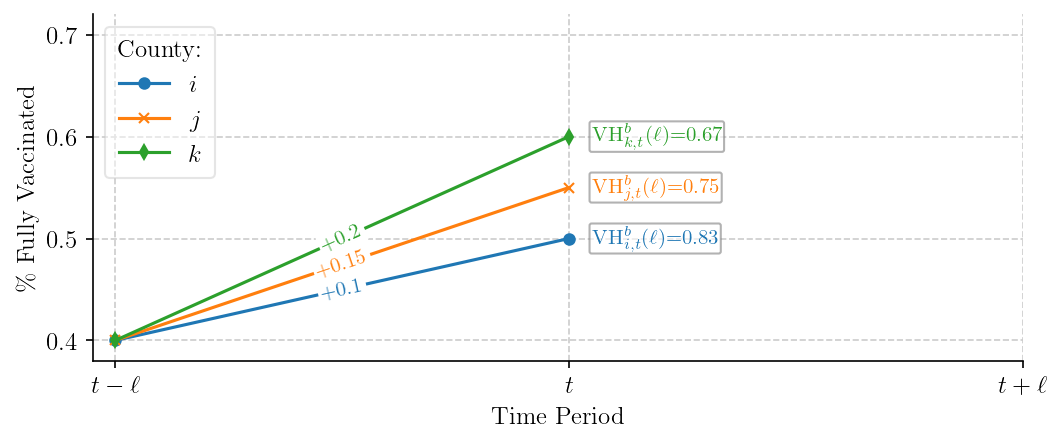

In [3]:
a_1, b_1, c_1 = 0.4, 0.4, 0.4

a_2, b_2, c_2 = a_1 + 0.1, b_1 + 0.15, c_1 + 0.2

a_3, b_3, c_3 = a_2 + 0.05, b_2 + 0.15, c_2 + 0.05


def get_rot(ax, x, y):
    p1 = ax.transData.transform_point((x[0], y[0]))
    p2 = ax.transData.transform_point((x[1], y[1]))
    dy = p2[1] - p1[1]
    dx = p2[0] - p1[0]
    return np.degrees(np.arctan2(dy, dx))


def get_VHb(a, b):
    return (1 - b) / (1 - a)


def plot_inc(ax, xs, ys, color, text, vhb_text, plot_inc=True, offset_x=0, offset_y=0):
    ax.annotate(
        text=vhb_text,
        xy=(xs[1] + 0.05, ys[1]),
        color=color,
        fontsize=10,
        bbox=dict(facecolor="white", edgecolor="grey", alpha=0.6, boxstyle="round,pad=.1"),
        ha="left",
        va="center",
    )
    if plot_inc:
        rot = get_rot(ax, xs, ys)
        ax.annotate(
            text=text,
            xy=(sum(xs) / 2 + offset_x, sum(ys) / 2 + offset_y),
            rotation=rot,
            ha="center",
            va="center",
            color=color,
            size=10,
            bbox=dict(facecolor="white", edgecolor="white", alpha=1, boxstyle="round,pad=.1"),
        )


fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 3), sharex=True, sharey=False)

ax.plot([1, 2], [a_1, a_2], color=colors[0], marker="o", markersize=5, label="$i$")
ax.plot([1, 2], [b_1, b_2], color=colors[1], marker="x", markersize=5, label="$j$")
ax.plot([1, 2], [c_1, c_2], color=colors[2], marker="d", markersize=5, label="$k$")

ax.set_ylim([0.38, 0.72])
ax.set_xticks([1, 2, 3])
ax.set_xticklabels([r"$t-\ell$", r"$t$", r"$t+\ell$"])
ax.set_xlabel("Time Period")
ax.set_ylabel(r"\% Fully Vaccinated")
ax.legend(
    loc="upper left",
    title="County:",
    fancybox=True,
    framealpha=0.5,
    borderpad=0.5,
    facecolor="white",
)

plot_inc(ax, [1, 2], [a_1, a_2], colors[0], "+0.1", f"VH$^b_{{i,t}}(\ell)$={get_VHb(a_1, a_2):.2f}")
plot_inc(ax, [1, 2], [b_1, b_2], colors[1], "+0.15", f"VH$^b_{{j,t}}(\ell)$={get_VHb(b_1, b_2):.2f}")
plot_inc(ax, [1, 2], [c_1, c_2], colors[2], "+0.2", f"VH$^b_{{k,t}}(\ell)$={get_VHb(c_1, c_2):.2f}")

add_grid(ax)
# plt.savefig("vhb_demo_1.png", dpi=400)

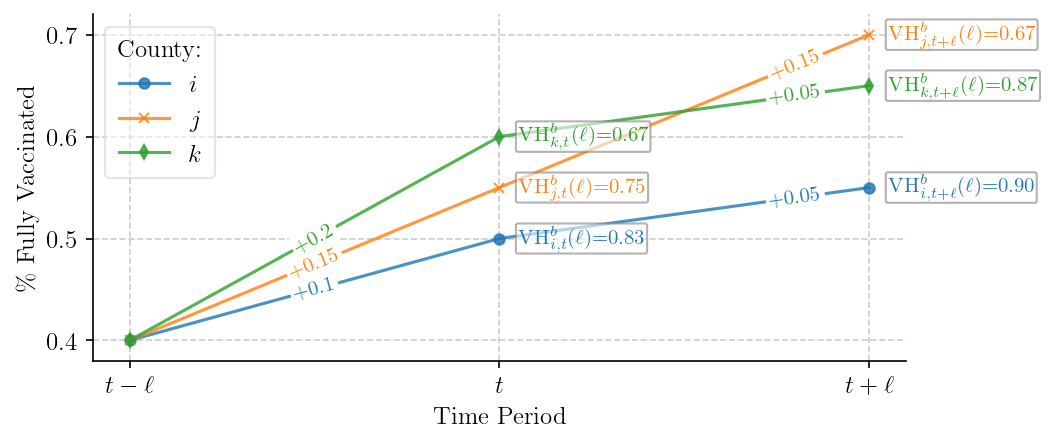

In [4]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 3), sharex=True, sharey=False)


ax.plot([1, 2, 3], [a_1, a_2, a_3], color=colors[0], marker="o", markersize=5, label="$i$", alpha=0.8)
ax.plot([1, 2, 3], [b_1, b_2, b_3], color=colors[1], marker="x", markersize=5, label="$j$", alpha=0.8)
ax.plot([1, 2, 3], [c_1, c_2, c_3], color=colors[2], marker="d", markersize=5, label="$k$", alpha=0.8)

ax.set_xticks([1, 2, 3])
ax.set_xticklabels([r"$t-\ell$", r"$t$", r"$t+\ell$"])
ax.set_xlabel("Time Period")
ax.set_ylabel(r"\% Fully Vaccinated")
ax.set_ylim([0.38, 0.72])

ax.legend(
    loc="upper left",
    title="County:",
    fancybox=True,
    framealpha=0.5,
    borderpad=0.5,
    facecolor="white",
)

plot_inc(ax, [1, 2], [a_1, a_2], colors[0], "+0.1", f"VH$^b_{{i,t}}(\ell)$={get_VHb(a_1, a_2):.2f}")
plot_inc(ax, [1, 2], [b_1, b_2], colors[1], "+0.15", f"VH$^b_{{j,t}}(\ell)$={get_VHb(b_1, b_2):.2f}")
plot_inc(ax, [1, 2], [c_1, c_2], colors[2], "+0.2", f"VH$^b_{{k,t}}(\ell)$={get_VHb(c_1, c_2):.2f}")

plot_inc(
    ax,
    [2, 3],
    [a_2, a_3],
    colors[0],
    "+0.05",
    f"VH$^b_{{i,t+\ell}}(\ell)$={get_VHb(a_2, a_3):.2f}",
    offset_x=0.3,
    offset_y=0.015,
)
plot_inc(
    ax,
    [2, 3],
    [b_2, b_3],
    colors[1],
    "+0.15",
    f"VH$^b_{{j,t+\ell}}(\ell)$={get_VHb(b_2, b_3):.2f}",
    offset_x=0.3,
    offset_y=0.045,
)
plot_inc(
    ax,
    [2, 3],
    [c_2, c_3],
    colors[2],
    "+0.05",
    f"VH$^b_{{k,t+\ell}}(\ell)$={get_VHb(c_2, c_3):.2f}",
    offset_x=0.3,
    offset_y=0.016,
)

add_grid(ax)
# plt.savefig("vhb_demo_2.png", dpi=400)

# RQ3


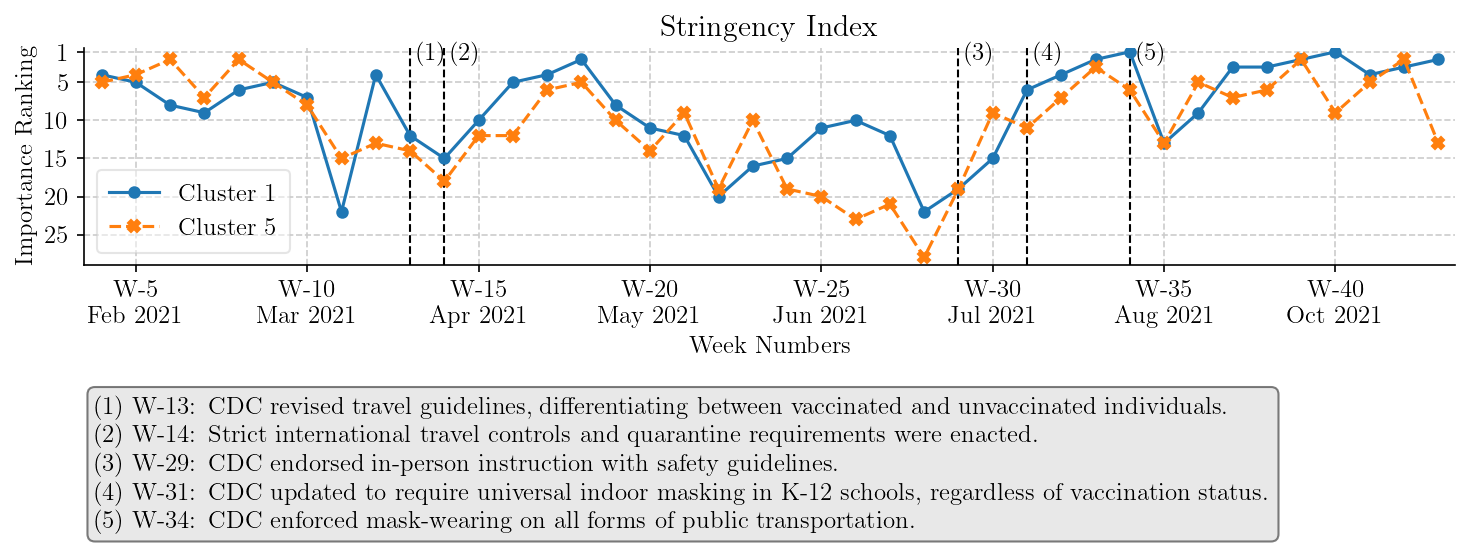

In [25]:
plot_df = pd.read_csv(f"{data_folder}/fig11_data.csv")

locator = mdates.MonthLocator(interval=1)  # every month
fmt = mdates.DateFormatter("W-%U (%b)")

fig, ax = plt.subplots(figsize=(10, 3))

for idx, i in enumerate([13, 14, 29, 31, 34], start=1):
    ax.axvline(x=i, c="black", ls="--", lw=1)
    ax.text(i + 0.2, 2, f"({idx})")

x = plot_df["Week"].to_list()
y_c1 = plot_df["C1 Ranking"].to_list()
y_c5 = plot_df["C5 Ranking"].to_list()
fname = plot_df["Feature"].values[0]

c1, c2 = "#1F77B4", "#FF7F0E"
ax.plot(x, y_c1, "o-", mfc=c1, ms=5, c=c1, label="Cluster 1")
ax.plot(x, y_c5, "X--", mfc=c2, ms=6, c=c2, label="Cluster 5")

ax.set_title("Stringency Index")
ax.set_xlabel("Week Numbers")
ax.set_ylabel("Importance Ranking")

ax.set_xlim(4 - 0.5, plot_df["Week"].max() + 0.5)

show_week_labels = plot_df[plot_df["week_number"].isin(np.arange(5, 41, 5))]["w_month_year"].to_list()
ax.set_xticks(np.arange(5, 41, 5).tolist())
ax.set_xticklabels(show_week_labels)

ax.set_ylim(0.5, plot_df[["C1 Ranking", "C5 Ranking"]].max().max() + 1)
ax.yaxis.set_major_locator(FixedLocator([1, 5, 10, 15, 20, 25, 30]))
ax.legend(facecolor="white", fancybox=True, framealpha=0.5, borderpad=0.5)

ax.text(
    0.075,
    -0.2,
    "(1) W-13: CDC revised travel guidelines, differentiating between vaccinated and unvaccinated individuals.\n"
    + "(2) W-14: Strict international travel controls and quarantine requirements were enacted.\n"
    + "(3) W-29: CDC endorsed in-person instruction with safety guidelines.\n"
    + "(4) W-31: CDC updated to require universal indoor masking in K-12 schools, regardless of vaccination status.\n"
    + "(5) W-34: CDC enforced mask-wearing on all forms of public transportation.",
    transform=plt.gcf().transFigure,
    bbox=dict(boxstyle="round", facecolor="lightgrey", alpha=0.5),
)

add_grid(ax)
ax.invert_yaxis()
plt.tight_layout()
plt.savefig(
    f"/Users/htbui/Active Projects/Project Stochastic Programming/visualization/Proposal/paper 1/RQ3.png",
    dpi=400,
    bbox_inches="tight",
)

# Introduction


In [5]:
vac_state_df = pd.read_csv(
    "/Volumes/Hieu Bui NVMe Drive/datasets/COVID-19/CDC/Vaccinations (State)/COVID-19_Vaccination_Trends_in_the_United_States_National_and_Jurisdictional.csv",
    parse_dates=["Date"],
    usecols=["Date", "Series_Complete_Cumulative", "date_type", "Location"],
)
STATES = [
    "AL",
    "AZ",
    "AR",
    "CA",
    "CO",
    "CT",
    "DE",
    "DC",
    "FL",
    "GA",
    "ID",
    "IL",
    "IN",
    "IA",
    "KS",
    "KY",
    "LA",
    "ME",
    "MD",
    "MA",
    "MI",
    "MN",
    "MS",
    "MO",
    "MT",
    "NE",
    "NV",
    "NH",
    "NJ",
    "NM",
    "NY",
    "NC",
    "ND",
    "OH",
    "OK",
    "OR",
    "PA",
    "RI",
    "SC",
    "SD",
    "TN",
    "TX",
    "UT",
    "VT",
    "VA",
    "WA",
    "WV",
    "WI",
    "WY",
]

pop = pd.read_csv(
    "/Volumes/Hieu Bui NVMe Drive/datasets/COVID-19/CENSUS/Population/census_2019.csv", dtype={"fips": str}
)
state_pop = pop[pop["state_name"] == pop["county"]].drop_duplicates(subset=["state_name"])[["state", "census_2019"]]

vac_state_df = vac_state_df[
    (vac_state_df["Date"] >= "2021-01-24")
    & (vac_state_df["Date"] <= "2021-12-31")
    & (vac_state_df["date_type"] == "Admin")
    & (vac_state_df["Location"].isin(STATES))
]
# (vac_state_df['Date'].dt.dayofweek == 6)]
vac_state_df["week_number"] = vac_state_df["Date"].dt.isocalendar().week
vac_state_df.rename(
    columns={"Series_Complete_Cumulative": "num_fully_vaccinated", "Date": "date", "Location": "state"}, inplace=True
)
vac_state_df.drop(columns=["date_type"], inplace=True)
vac_state_df = vac_state_df.merge(state_pop, on="state", how="left")
vac_state_df["perc_fully_vaccinated"] = vac_state_df["num_fully_vaccinated"] / vac_state_df["census_2019"]
vac_state_df.sort_values(by=["date", "state"], inplace=True)


vac_US_df = (
    vac_state_df.groupby(["week_number", "date"])
    .agg({"num_fully_vaccinated": "sum", "census_2019": "sum"})
    .reset_index()
)
vac_US_df["perc_fully_vaccinated"] = vac_US_df["num_fully_vaccinated"] / vac_US_df["census_2019"]

In [17]:
fig = go.Figure(
    layout=dict(
        template="ggplot2",
        margin=dict(l=50, r=10, b=50, t=20, pad=0),
        font=dict(family="CMU Serif", size=15, color="rgb(37,37,37)"),
    )
).set_subplots(
    rows=1,
    cols=3,
    horizontal_spacing=0.02,
    shared_yaxes=True,
    subplot_titles=["<b>a)</b> United States", "<b>b)</b> Arkansas", "<b>c)</b> Vermont"],
)
AR_df = vac_state_df[vac_state_df["state"] == "AR"]
VT_df = vac_state_df[vac_state_df["state"] == "VT"]

for state in vac_state_df["state"].unique():
    temp_df = vac_state_df[vac_state_df["state"] == state]
    if state == "AR":
        linewidth = 2
        color = colors[0]
    elif state == "VT":
        color = colors[1]
        linewidth = 2
    else:
        color = "lightslategrey"
        linewidth = 0.5
    fig.add_trace(
        go.Scatter(
            x=temp_df["date"],
            y=temp_df["perc_fully_vaccinated"],
            name=state,
            mode="lines+text",
            marker=dict(color=color),
            line=dict(width=linewidth),
            opacity=1,
        ),
        row=1,
        col=1,
    )
fig.add_trace(
    go.Scatter(
        x=vac_US_df["date"],
        y=vac_US_df["perc_fully_vaccinated"],
        name="US",
        mode="lines",
        marker=dict(color="crimson"),
        line=dict(width=2),
    ),
    row=1,
    col=1,
)

fig.add_trace(
    go.Scatter(
        x=AR_df["date"],
        y=AR_df["perc_fully_vaccinated"],
        mode="lines",
        fill="tonexty",
        marker=dict(color=colors[0]),
        line=dict(width=2),
    ),
    row=1,
    col=2,
)

fig.add_trace(
    go.Scatter(
        x=VT_df["date"],
        y=VT_df["perc_fully_vaccinated"],
        mode="lines",
        fill="tonexty",
        marker=dict(color=colors[1]),
        line=dict(width=2),
    ),
    row=1,
    col=3,
)


fig.add_trace(
    go.Scatter(
        x=[datetime.datetime(2021, 10, 28)],
        y=[0.584772 - 0.01],
        text="<b>US</b>",
        textposition="bottom left",
        textfont=dict(color="crimson"),
        mode="text",
    ),
    row=1,
    col=1,
)
fig.add_trace(
    go.Scatter(
        x=[datetime.datetime(2021, 10, 28)],
        y=[0.458668 - 0.01],
        text="<b>Arkansas</b>",
        textposition="bottom left",
        textfont=dict(color=colors[0]),
        mode="text",
    ),
    row=1,
    col=1,
)
fig.add_trace(
    go.Scatter(
        x=[datetime.datetime(2021, 10, 28)],
        y=[0.725514 - 0.01],
        text="<b>Vermont</b>",
        textposition="top left",
        textfont=dict(color=colors[1]),
        mode="text",
    ),
    row=1,
    col=1,
)

fig.add_trace(
    go.Scatter(
        x=[datetime.datetime(2021, 10, 28)],
        y=[0.490861],
        text="<b>49.09%</b>",
        textposition="top left",
        textfont=dict(color="black"),
        mode="text",
    ),
    row=1,
    col=2,
)
fig.add_trace(
    go.Scatter(
        x=[datetime.datetime(2021, 10, 28)],
        y=[0.725514],
        text="<b>72.55%</b>",
        textposition="top left",
        textfont=dict(color="black"),
        mode="text",
    ),
    row=1,
    col=3,
)


fig.update_layout(
    height=250,
    width=800,
    xaxis=dict(title="Date", tickformat="%b\n%Y", range=["2021-01-24", "2021-10-31"]),
    xaxis2=dict(title="Date", tickformat="%b\n%Y", range=["2021-01-24", "2021-10-31"]),
    xaxis3=dict(title="Date", tickformat="%b\n%Y", range=["2021-01-24", "2021-10-31"]),
    yaxis=dict(title="% Fully Vaccinated", tickformat=",.0%", range=[0, 0.85], titlefont_size=15),
    showlegend=False,
)
fig.write_image(f"{image_folder}/vaccination_trend.png", scale=4)

In [11]:
df = pd.read_csv(
    "/Volumes/Hieu Bui NVMe Drive/datasets/COVID-19/CDC/Vaccinations (County)/Jan_28_2022_COVID-19_Vaccinations_in_the_United_States_County.csv",
    parse_dates=["Date"],
    usecols=[
        "Date",
        "FIPS",
        "MMWR_week",
        "Recip_County",
        "Recip_State",
        "Completeness_pct",
        "Series_Complete_Yes",
        "Series_Complete_Pop_Pct",
        "Census2019",
        "Metro_status",
    ],
)
df["Day_of_Week"] = df["Date"].dt.day_name()
df["Year"] = df["Date"].dt.year

# Filter out the data for the counties we want
df = df[
    (df["Year"] == 2021)
    & (df["Date"] >= "2021-01-24")
    & (df["Date"] <= "2021-10-31")
    & (~df["Recip_State"].isin(["AK", "HI", "PR", "GU", "MP", "MH", "PW", "FM", "UNK", "AS", "VI"]))
]

In [19]:
from plotly.subplots import make_subplots

test_df = df[
    (df["Series_Complete_Pop_Pct"] != 0)
    & (df["Date"] == "2021-10-30")
    & (~df["Recip_State"].isin(["AK", "HI", "PR", "GU", "MP", "MH", "PW", "FM", "UNK", "AS", "VI"]))
    & (~df["Recip_County"].isin(["Unknown County"]))
]
test_df = (
    test_df[["FIPS", "Recip_County", "Recip_State", "Metro_status", "Census2019", "Series_Complete_Pop_Pct"]]
    .copy()
    .drop_duplicates(subset=["Recip_County", "Recip_State"], keep="first")
)

plot1 = test_df[test_df["Metro_status"] == "Metro"]
plot2 = test_df[test_df["Metro_status"] != "Metro"]
plot3 = test_df[(test_df["Metro_status"] == "Metro") & (test_df["Recip_State"] == "AR")]
plot4 = test_df[(test_df["Metro_status"] != "Metro") & (test_df["Recip_State"] == "AR")]


fig = make_subplots(
    rows=1,
    cols=3,
    subplot_titles=[
        f"<b>d)</b> U.S. Metro Counties: {plot1.shape[0]:,.0f}",
        f"<b>e)</b> U.S. Non-Metro Counties: {plot2.shape[0]:,.0f}",
        "",
    ],
    column_widths=[0.43, 0.43, 0.15],
    shared_xaxes=True,
    shared_yaxes=True,
    horizontal_spacing=0.02,
    vertical_spacing=0.15,
)


fig.add_trace(
    go.Scattergl(
        x=plot1["Census2019"],
        y=plot1["Series_Complete_Pop_Pct"],
        mode="markers",
        name="Metro",
        marker=dict(color=colors[0], size=5, opacity=0.4, line=dict(width=0.5, color="DarkSlateGrey")),
    ),
    row=1,
    col=1,
)
fig.add_trace(
    go.Scattergl(
        x=plot2["Census2019"],
        y=plot2["Series_Complete_Pop_Pct"],
        mode="markers",
        name="Non-Metro",
        marker=dict(color=colors[1], size=5, opacity=0.4, line=dict(width=0.5, color="DarkSlateGrey")),
    ),
    row=1,
    col=2,
)


fig.add_trace(
    go.Histogram(
        y=plot1["Series_Complete_Pop_Pct"],
        ybins_size=2,
        histnorm="percent",
        marker=dict(color=colors[0], line=dict(width=0.2, color="black")),
        opacity=0.8,
    ),
    row=1,
    col=3,
)
fig.add_trace(
    go.Histogram(
        y=plot2["Series_Complete_Pop_Pct"],
        ybins_size=2,
        histnorm="percent",
        marker=dict(color=colors[1], line=dict(width=0.2, color="black")),
        opacity=0.6,
    ),
    row=1,
    col=3,
)

fig.update_layout(
    font=dict(family="CMU Serif", size=15, color="rgb(37,37,37)"),
    template="ggplot2",
    width=1000,
    height=250,
    margin=dict(l=30, r=20, b=50, t=20, pad=0),
    showlegend=False,
    barmode="overlay",
    xaxis=dict(title="Population (<i>Log scale</i>)", tickfont=dict(size=12), type="log"),
    xaxis2=dict(title="Population (<i>Log scale</i>)", tickfont=dict(size=12), type="log"),
    xaxis3=dict(title="Fraction of counties"),
    yaxis=dict(
        title="% Fully Vaccinated<br><sup>October 30, 2021</sup>", range=[-5, 105], ticksuffix="%", titlefont_size=16
    ),
    yaxis4=dict(title="% Fully Vaccinated<br><sup>October 30, 2021</sup>", range=[-5, 105]),
)
fig.show()
fig.write_image(f"{image_folder}/vaccination_pop_county.png", scale=4)